In [7]:
import os

import numpy
import pyextremes
import pandas
import scipy
import seaborn
import xarray

%matplotlib inline

In [4]:
workspace_dir = '../../all_models_experiments'
bootstrapped_dates_path = os.path.join(workspace_dir, 'intermediate', 'bootstrapped_dates_precip_CanESM5_ssp126.csv')
historical_data_path = os.path.join(workspace_dir, 'intermediate', 'mswep_mean.nc')

In [5]:
future_data = pandas.read_csv(bootstrapped_dates_path, parse_dates={'date': [0]})
future_data.set_index('date', inplace=True)
future_data = future_data['historic_precip']

In [26]:
with xarray.open_dataset(historical_data_path) as dataset:
    # print(dataset)
    dataset = dataset.sortby('time')
    historical_data = dataset.sel(time=slice('1980-01-01', '2010-12-31')).precipitation.to_series()

In [11]:
thresholds = range(0, 30)

<AxesSubplot: xlabel='Threshold', ylabel='Mean excess'>

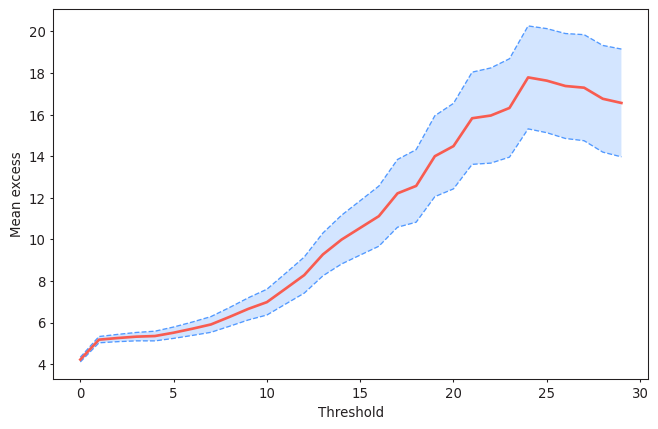

In [12]:
pyextremes.plot_mean_residual_life(future_data, thresholds=thresholds)

(<AxesSubplot: ylabel='Shape, $\\xi$'>,
 <AxesSubplot: xlabel='Threshold', ylabel='Modified scale, $\\sigma^*$'>)

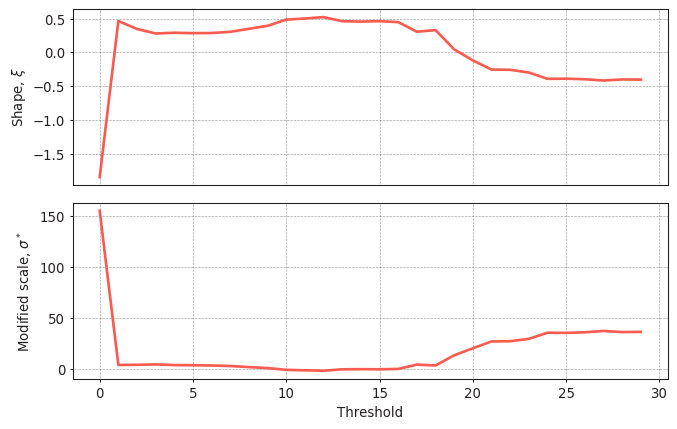

In [13]:
pyextremes.plot_parameter_stability(future_data, thresholds=thresholds)

In [14]:
threshold = 20
threshold_percentile = sum(future_data < threshold) / len(future_data) * 100

In [15]:
threshold_percentile

98.1554195963839

(<Figure size 768x480 with 1 Axes>,
 <AxesSubplot: xlabel='date', ylabel='historic_precip'>)

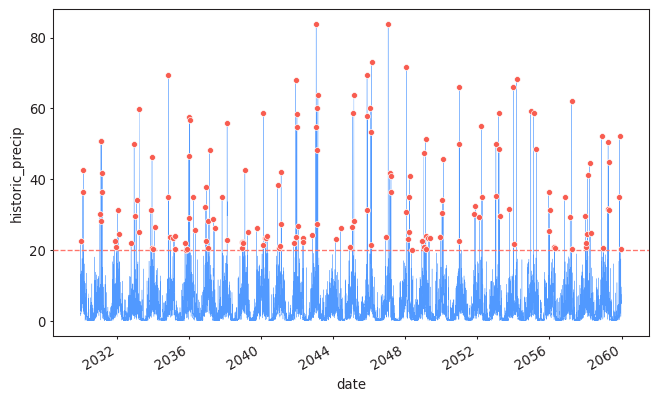

In [16]:
model = pyextremes.EVA(data=future_data)
model.get_extremes(
    method='POT',
    extremes_type='high',
    threshold=threshold
)
model.plot_extremes()

In [21]:
model.fit_model(distribution='genpareto')
print(model)

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:               historic_precip      Size:                              10,951
Start:                       January 2030      End:                         January 2060
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                165      Extraction method:                    POT
Type:                                high      Threshold:                             20
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

In [22]:
c = model.distribution.mle_parameters['c']
scale = model.distribution.mle_parameters['scale']
loc = model.distribution.fixed_parameters['floc']
sample = scipy.stats.genpareto.rvs(c, loc, scale, size=10000)

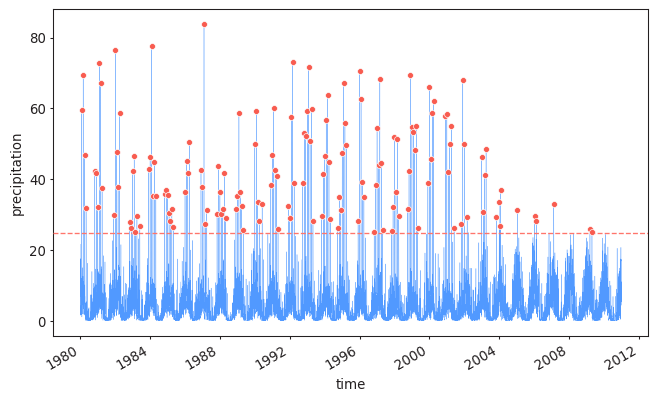

In [27]:
historic_threshold = numpy.percentile(historical_data, threshold_percentile)
h_model = pyextremes.EVA(data=historical_data)
h_model.get_extremes(
    method='POT',
    extremes_type='high',
    threshold=historic_threshold
)
h_model.plot_extremes()
h_model.fit_model()

In [28]:
c = h_model.distribution.mle_parameters['c']
scale = h_model.distribution.mle_parameters['scale']
loc = h_model.distribution.fixed_parameters['floc']
h_sample = scipy.stats.genpareto.rvs(c, loc, scale, size=10000)

In [31]:
df = pandas.DataFrame({
    'future_sample': sample,
    'historic_sample': h_sample
})

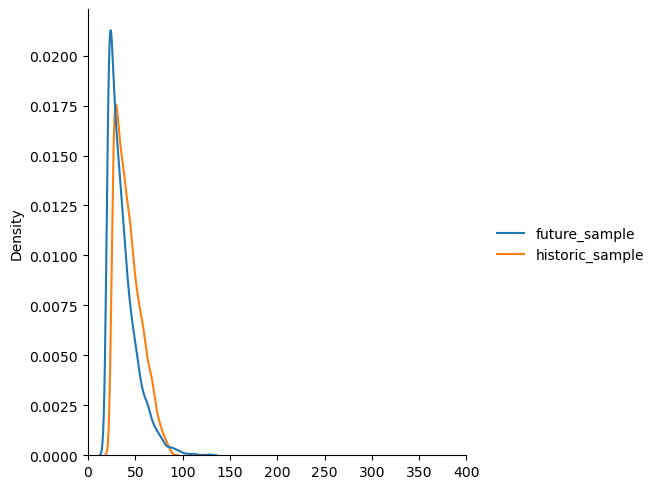

In [32]:
plt = seaborn.displot(df, kind='kde')
plt.set(xlim=(0, 400))